# Project 4: Clustering Cat Breeds
Exploring natural groupings in cat traits to see how lifestyle, physique, and caretaking patterns cluster across breeds.

## Load Data
The dataset used for this analysis is `cat_breeds_clean.csv`. It contains information about various cat breeds, including their physical stats and daily lives.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', 50)
sns.set_theme(style='whitegrid', palette='muted')

In [20]:
data_path = 'cat_breeds_clean.csv'
df = pd.read_csv(data_path, sep=';')

df.shape, df.head()

((1071, 17),
     Breed  Age_in_years  Age_in_months  Gender  Neutered_or_spayed  \
 0  Angora          0.25              3  female               False   
 1  Angora          0.33              4    male               False   
 2  Angora          0.50              6    male               False   
 3  Angora          0.50              6  female               False   
 4  Angora          0.50              6    male               False   
 
    Body_length  Weight Fur_colour_dominant Fur_pattern Eye_colour  \
 0           19     2.0               white       solid       blue   
 1           19     2.5               white       solid       blue   
 2           20     2.8               black       solid      green   
 3           21     3.0               white       solid       blue   
 4           21     3.0           red/cream       tabby      green   
 
    Allowed_outdoor Preferred_food  Owner_play_time_minutes  Sleep_time_hours  \
 0            False            wet                      

## Introduce the Data
*   **Key Features:**
    *   **Physical:** `Body_length`, `Weight`, `Fur_colour_dominant`, `Eye_colour`.
    *   **Lifestyle:** `Allowed_outdoor`, `Owner_play_time_minutes`, `Sleep_time_hours`.
    *   **Demographics:** `Breed`, `Age_in_years`, `Gender`, `Country`.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071 entries, 0 to 1070
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Breed                    1071 non-null   object 
 1   Age_in_years             1071 non-null   float64
 2   Age_in_months            1071 non-null   int64  
 3   Gender                   1071 non-null   object 
 4   Neutered_or_spayed       1071 non-null   bool   
 5   Body_length              1071 non-null   int64  
 6   Weight                   1071 non-null   float64
 7   Fur_colour_dominant      1071 non-null   object 
 8   Fur_pattern              1071 non-null   object 
 9   Eye_colour               1071 non-null   object 
 10  Allowed_outdoor          1071 non-null   bool   
 11  Preferred_food           1071 non-null   object 
 12  Owner_play_time_minutes  1071 non-null   int64  
 13  Sleep_time_hours         1071 non-null   int64  
 14  Country                 

In [22]:
df.isnull().sum()

Breed                      0
Age_in_years               0
Age_in_months              0
Gender                     0
Neutered_or_spayed         0
Body_length                0
Weight                     0
Fur_colour_dominant        0
Fur_pattern                0
Eye_colour                 0
Allowed_outdoor            0
Preferred_food             0
Owner_play_time_minutes    0
Sleep_time_hours           0
Country                    0
Latitude                   0
Longitude                  0
dtype: int64

## Data Understanding / Visualization

In [23]:
df['Breed'].value_counts()

Breed
Ragdoll       435
Maine coon    342
Angora        294
Name: count, dtype: int64

In [24]:
numeric_cols = ['Age_in_years', 'Age_in_months', 'Body_length', 'Weight', 'Owner_play_time_minutes', 'Sleep_time_hours', 'Latitude', 'Longitude']
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Age_in_years,1071.0,4.845462,2.737469,0.080000,2.67000,4.92000,7.040000,11.250000
Age_in_months,1071.0,58.145658,32.849889,1.000000,32.00000,59.00000,84.500000,135.000000
Body_length,1071.0,44.003735,16.310308,10.000000,35.00000,41.00000,51.000000,102.000000
Weight,1071.0,5.494613,2.292242,0.500000,3.90000,5.00000,7.075000,12.100000
Owner_play_time_minutes,1071.0,23.049486,10.840922,0.000000,14.00000,23.00000,31.000000,60.000000
Sleep_time_hours,1071.0,15.889823,2.621443,8.000000,14.00000,16.00000,18.000000,22.000000
Latitude,1071.0,44.439720,4.965876,37.774930,40.71427,42.35843,48.864716,53.800755
Longitude,1071.0,-60.178554,45.364141,-123.116226,-77.03637,-74.00597,-1.890401,13.404954


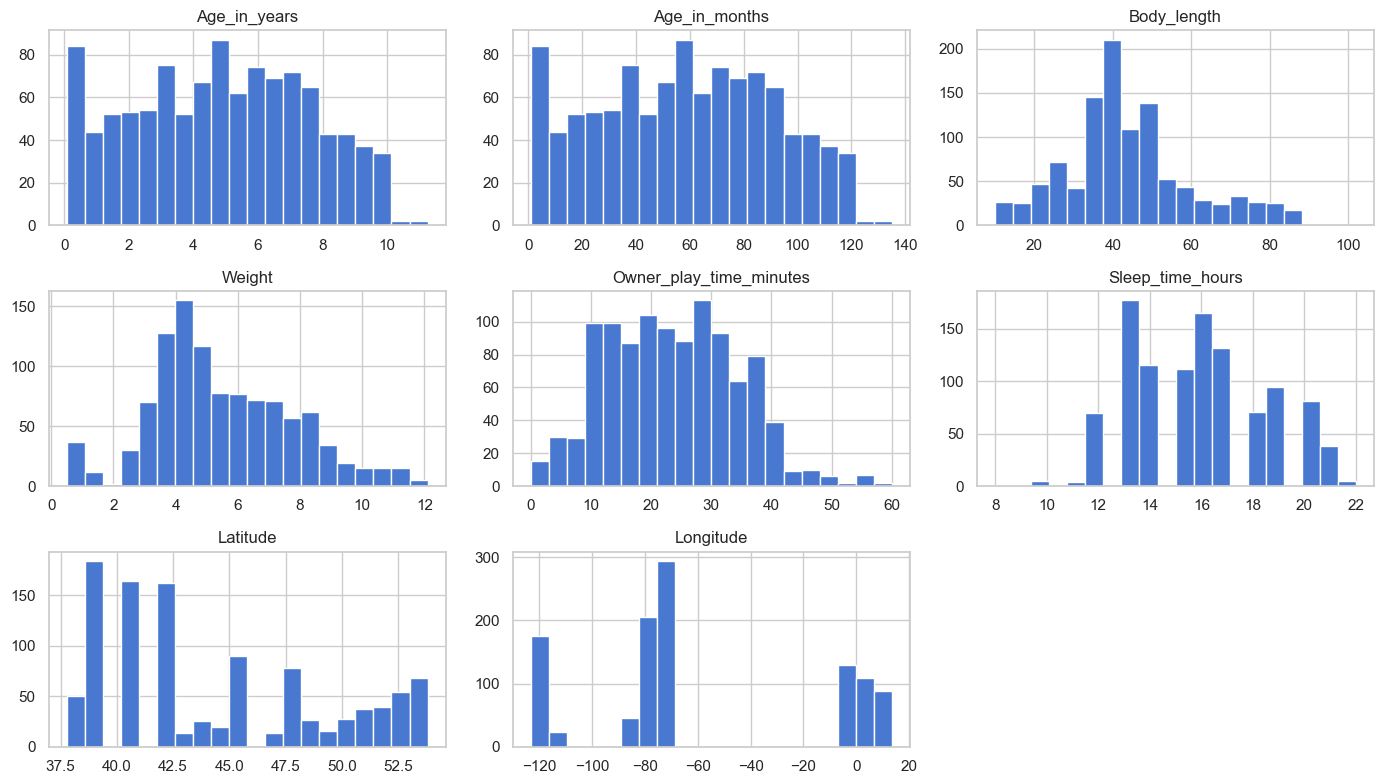

In [25]:
df[numeric_cols].hist(figsize=(14, 8), bins=20)
plt.tight_layout()
plt.show()

## Pre-processing the Data

In [26]:
df = df.copy()
bool_cols = ['Neutered_or_spayed', 'Allowed_outdoor']
for col in bool_cols:
    df[col] = df[col].astype(str).str.lower().map({'true': True, 'false': False})

numeric_features = ['Age_in_years', 'Body_length', 'Weight', 'Owner_play_time_minutes', 'Sleep_time_hours', 'Latitude', 'Longitude']
categorical_features = ['Breed', 'Gender', 'Fur_colour_dominant', 'Fur_pattern', 'Eye_colour', 'Preferred_food', 'Country', 'Neutered_or_spayed', 'Allowed_outdoor']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

X = preprocessor.fit_transform(df)
X.shape

(1071, 39)

## Modeling (Clustering)

In [27]:
results = []
k_values = [2, 3, 4, 5, 6]
for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    inertia = km.inertia_
    results.append({'k': k, 'silhouette': sil, 'davies_bouldin': dbi, 'inertia': inertia})

metrics_df = pd.DataFrame(results)
metrics_df

c:\Users\Legen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\Legen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\Legen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\Legen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

,k,silhouette,davies_bouldin,inertia
0,2,0.178915,2.146027,10637.638856
1,3,0.157507,1.976328,9451.363411
2,4,0.144461,2.042406,8679.877634
3,5,0.141276,1.899610,8112.391128
4,6,0.153753,1.997120,7677.724601


In [28]:
best_row = metrics_df.sort_values(by='silhouette', ascending=False).iloc[0]
best_k = int(best_row['k'])
best_row

k                     2.000000
silhouette            0.178915
davies_bouldin        2.146027
inertia           10637.638856
Name: 0, dtype: float64

In [29]:
# Fit final k-means
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Fit agglomerative with same k for comparison
agg = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
agg_labels = agg.fit_predict(X)

df_clusters = df.copy()
df_clusters['kmeans_cluster'] = kmeans_labels
df_clusters['agg_cluster'] = agg_labels
df_clusters[['Breed', 'kmeans_cluster', 'agg_cluster']].head()

c:\Users\Legen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


,Breed,kmeans_cluster,agg_cluster
0,Angora,0,1
1,Angora,0,1
2,Angora,0,1
3,Angora,0,1
4,Angora,0,1


In [30]:
# External reference: how well clusters align with given Breed labels (informational only)
ari_kmeans = adjusted_rand_score(df['Breed'], kmeans_labels)
ari_agg = adjusted_rand_score(df['Breed'], agg_labels)
{'adjusted_rand_kmeans': ari_kmeans, 'adjusted_rand_agg': ari_agg}

{'adjusted_rand_kmeans': 0.0141129731014246,
 'adjusted_rand_agg': 0.02709389107134095}

## Visualization (PCA for 2D view)

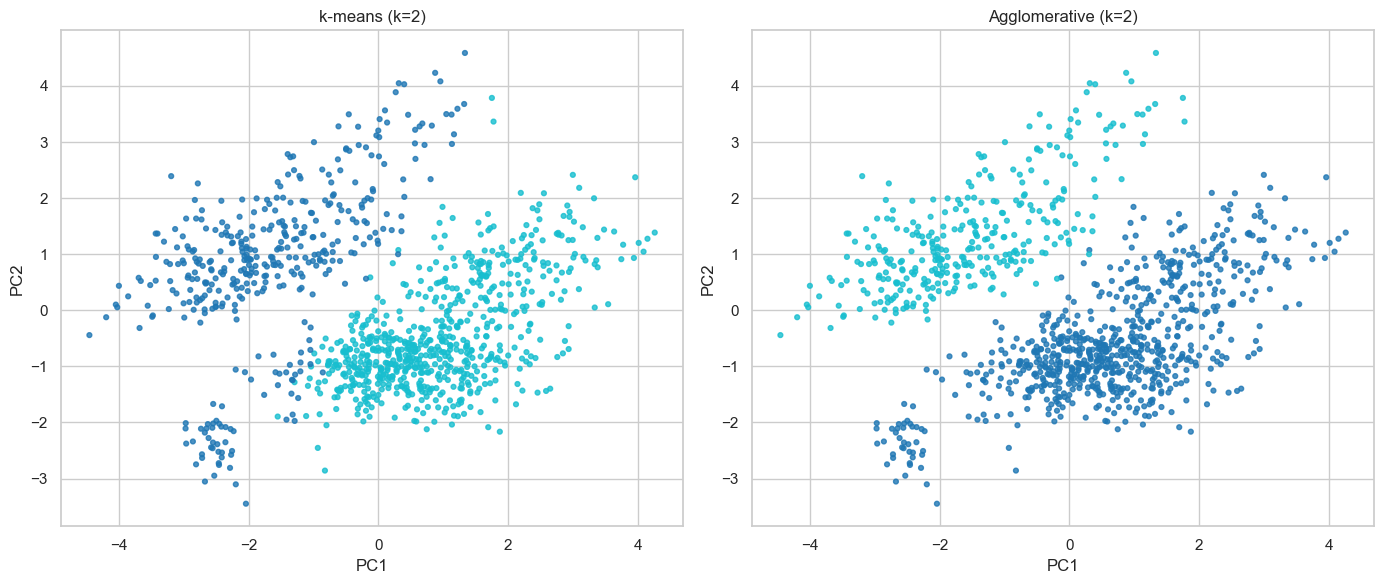

In [32]:
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X.toarray() if hasattr(X, 'toarray') else X)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
scatter = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans_labels, cmap='tab10', s=12, alpha=0.8)
axes[0].set_title(f'k-means (k={best_k})')

axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=agg_labels, cmap='tab10', s=12, alpha=0.8)
axes[1].set_title(f'Agglomerative (k={best_k})')

for ax in axes:
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

plt.tight_layout()
plt.savefig('Images/pca_clusters.png')
plt.show()

## Storytelling: Cluster Profiles

In [17]:
def describe_clusters(frame, label_col):
    summary_num = frame.groupby(label_col)[numeric_features].mean().round(2)
    summary_cat = frame.groupby(label_col)[['Breed', 'Preferred_food', 'Allowed_outdoor']].agg(lambda x: x.value_counts().index[0])
    return summary_num, summary_cat

km_num, km_cat = describe_clusters(df_clusters, 'kmeans_cluster')
agg_num, agg_cat = describe_clusters(df_clusters, 'agg_cluster')

km_num, km_cat

(                Age_in_years  Body_length  Weight  Owner_play_time_minutes  \
 kmeans_cluster                                                               
 0                       2.84        36.39    4.24                    26.68   
 1                       6.01        48.40    6.22                    20.95   
 
                 Sleep_time_hours  Latitude  Longitude  
 kmeans_cluster                                         
 0                          15.99     48.85     -12.62  
 1                          15.83     41.90     -87.63  ,
                   Breed Preferred_food  Allowed_outdoor
 kmeans_cluster                                         
 0               Ragdoll            wet            False
 1               Ragdoll            wet            False)